In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import scipy.signal as sig

The goal of this ntoebook is to establish a baseline relationship between time delay (s) and flow rate (gpm)

In [2]:
tempPath = '../data/thermalBenchSmTest_01/tof_test_temp_06.csv'
flowPath = '../data/thermalBenchSmTest_01/tof_test_flow_06.csv'
dt = 0.1

Temp = pd.read_csv(tempPath)
Flow = pd.read_csv(flowPath)

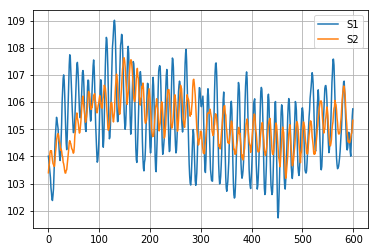

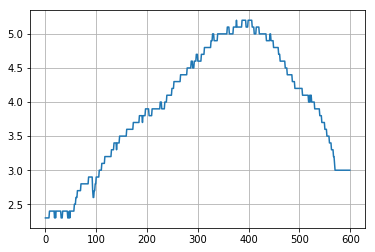

In [3]:
S1 = Temp['Temperature - cold']
S2 = Temp['Temperature - mix']
flow = Flow['Flow (gpm) - mix']

plt.plot(S1,label='S1')
plt.plot(S2,label='S2')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(flow)
plt.grid(True)
plt.show()

In [4]:
flow.argmin()

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


0

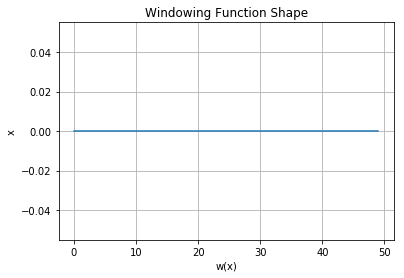

In [5]:
def windowFun(xs):
    l = len(xs)
    # maybe define this a-priori to increase run-speed
    w = sig.windows.hann(l)
    a = np.dot(xs,w)/sum(w)
    return (xs-a) * w

def windowFast(xs,w):
    #l = len(xs)
    # maybe define this a-priori to increase run-speed
    #w = sig.windows.hann(l)
    a = np.dot(xs,w)/sum(w)
    return (xs-a) * w

if 1:
    plt.plot(windowFun(np.ones(50)))
    plt.title('Windowing Function Shape')
    plt.xlabel('w(x)')
    plt.ylabel('x')
    plt.grid()

## Make the signal and test it

In [6]:
#samplingRate = 10   # hz
#dT = 1/samplingRate # sec
#tf = 150
#n = tf/dT+1

#ts = np.arange(start=0,stop=tf,step=dT)

#dt = 300 # We are setting the time delay to be 300 steps
l = len(S1)
t = np.arange(0,l)*dt
#start = 0

# Create the simulated data sets for the sensor signals
#u = voss(len(ts))
#v = voss(len(ts))
#S1 = u[ (start+dt) : (start+dt+l) ]
#S2 = u[ start:(start+l) ]
#t = ts[ :l]

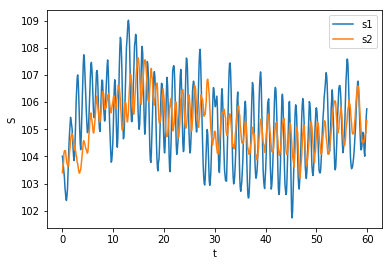

In [7]:
plt.plot(t,S1)
plt.xlabel('t')
#plt.ylabel('S1')
plt.plot(t,S2)
plt.xlabel('t')
plt.ylabel('S')
plt.legend(['s1','s2'])
plt.show()

In [8]:
# compute means and center the data
S1m = sum(S1)/len(S1)
S2m = sum(S2)/len(S2)
print(S1m)
print(S2m)
s1 = S1-S1m
#s1t = S1t-S1m
s2 = S2-S2m

105.22539999999992
105.21035000000002


Correlation and convolution functions both struggle with edge effects (as famously deomnstrated with fourier transform windowing issues). One way to solve this problem is to amke a windowing function that makes the signal appear to periodically repeat in the sampling window.

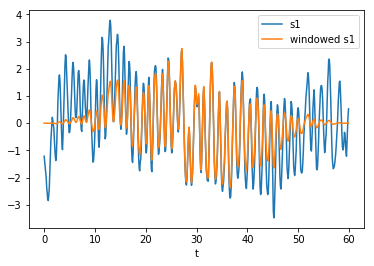

In [9]:
# plot s1 and it's windowed version side-by-side
plt.plot(t,s1)
plt.plot(t,windowFun(s1))
plt.legend(['s1','windowed s1'])
plt.xlabel('t')
plt.show()

Text(0,0.5,'amplitude')

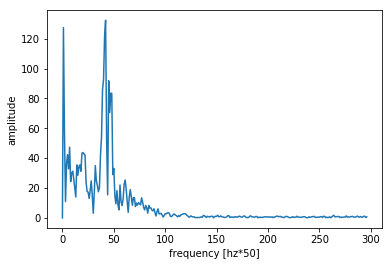

In [10]:
ans = sp.fft(windowFun(s1))

plt.plot(np.abs(ans[0:594//2]))
plt.xlabel('frequency [hz*50]')
plt.ylabel('amplitude')

In [11]:
#sig.spectrogram(s1,10)
#f, t, Sxx = sig.spectrogram(s1, 10)
#nor = mpl.colors.Normalize(vmin=0, vmax=5, clip=True)
#plt.pcolormesh(t, f, Sxx, shading='gouraud',norm=nor)
#plt.title('Signal Spectral Density')
#plt.ylabel('Frequencies [Hz-ish]')
#plt.xlabel('Time [s]')
#plt.show()

### A quick correlation scatter plot shows that, due to the time-shift, there is no correlation between the signals 

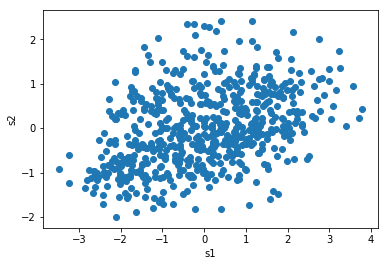

In [12]:
plt.scatter(s1,s2)
plt.xlabel('s1')
plt.ylabel('s2')
plt.show()

Let's look at the variance of the two signals to get an idea of how big the noise is:

In [13]:
s1v = np.var(s1)
s2v = np.var(s2)
print(s1v)
print(s2v)

2.04531784
0.7578547108333343


As a reminder of what covariance is: 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Covariance_trends.svg/340px-Covariance_trends.svg.png)

Compute the covariance between x and y

In [14]:
covar = np.cov([s1,s2])[1,0]
print(covar)

0.4941790751252086


Compute the correlation between x and y

In [15]:
corr = covar/np.sqrt(s1v*s2v)
print(corr)

0.39692730162673


In [16]:
# compute the correlated lag between x and y
# xLag is currently expressed in number of time steps
def corrLag(s1,s2,xLag,show=False,window=False):
    n = len(s1)
    if window:
        s = np.dot( windowFun( s2[int(xLag):]   ),
                    windowFun( s1[:int(n-xLag)] ) )    
    else: 
        s = np.dot(s2[int(xLag):],s1[:int(n-xLag)])
    #s = 0
    #for i in range(n-xLag):
    #    s += x[i+xLag]*y[i]
    cov = np.cov([s1,s2])[0,1]
    
    if show:
        plt.scatter(s2[xLag:],s1[:(n-xLag)])
        plt.xlabel('s2')
        plt.ylabel('s1')
    
    # this equation is taken from the 2.131 notes
    return s/cov/(n-xLag)

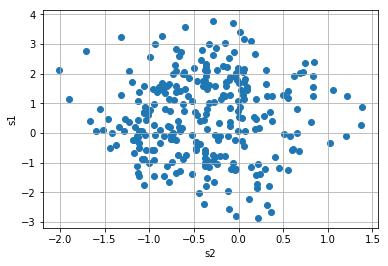

In [17]:
corrLag(s1,s2,320,show=True)
plt.grid(True)

In [18]:
def corrSweep(x,y,lags,show=False,window=False):
    crossCorr = np.zeros(len(lags))
    for i,lag in enumerate(lags):
        crossCorr[i] = corrLag(x,y,lag,window=window)
    
    if show:
        sign = np.sign( crossCorr[np.argmax(abs(crossCorr))] )
        plt.plot( lags,crossCorr/max(abs(crossCorr))*sign ) 
        plt.xlabel('lag')
        plt.ylabel('Cross-correlation')
        plt.grid(True)
    
    return crossCorr, abs(crossCorr).argmax()

In [19]:
# using built-in signal processing tools from python to compute
# the correlation
def fastCorr(s1,s2,show=False):
    FF = sig.correlate(tuple(s2),tuple(s1))
    l = len(s1)
    # assume that we know what direction the time lag will be in
    ff = FF[l:]
    lags = range(0,int(l)-1)
    if show:
        plt.plot(lags,ff/max(ff))
        plt.grid(True)
    return abs(ff).argmax()

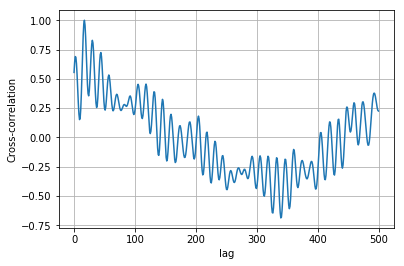

In [20]:
lags = np.arange(0,500)
_, s = corrSweep(s1,s2,lags,True)

The real lag of the data is incorrectly estimated by this basic function:

In [21]:
print(s)

17


This mistake can be clearly seen in this plot:

1.800384560819547

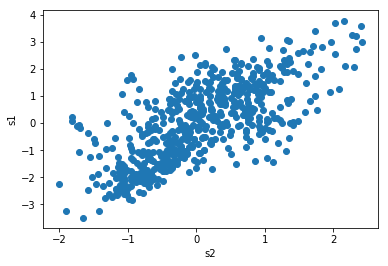

In [22]:
corrLag(s1,s2,s,True)

When compared to:

0.7142349613230194

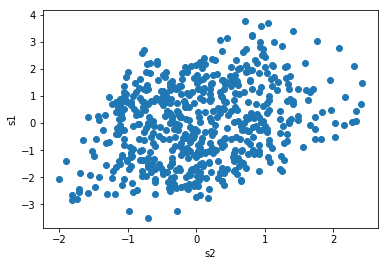

In [23]:
corrLag(s1,s2,25,True)

Now, let's see what effect random noise has on this technique:

17


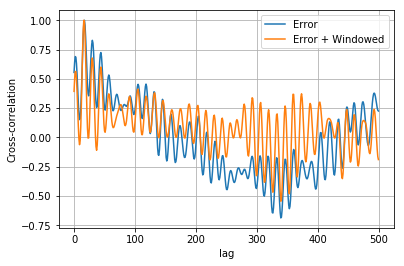

16


In [24]:
s2w = windowFun(s2)
s1w = windowFun(s1)

_,E = corrSweep(s1,s2,lags,show=True)
print(E)

_,EW = corrSweep(s1,s2,lags,show=True,window=True)
plt.title('')
plt.legend(['Error','Error + Windowed'])
plt.show()
print(EW)

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


16
15
16
15


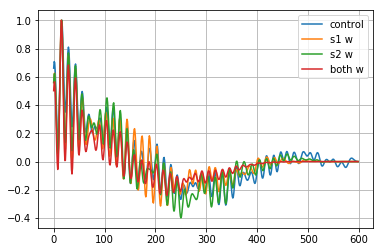

In [25]:
b = fastCorr(s1,s2,show=True)
w1 = fastCorr(s1w,s2,show=True)
w2 = fastCorr(s1,s2w,show=True)
w12 = fastCorr(s1w,s2w,show=True)

plt.legend(['control','s1 w','s2 w','both w'])
print(b)
print(w1)
print(w2)
print(w12)

Now, let's see what effect that diffusion (a good proxy for turbulent mixing) has on this:

it seems that a calibration factor of:

In [26]:
round((w1*dt)*( sum(flow)/len(flow) ),4)

5.863

is appropriate. I'm going to use 6.17 for future work. The units are [sec]*[gpm]

In [27]:
type(s1)

pandas.core.series.Series

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


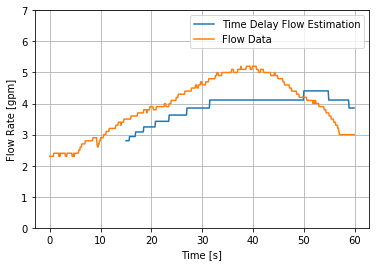

In [36]:
l = 150

tds = range(l,len(s2))
res = np.zeros(len(tds))

for i,td in enumerate(tds):
    s1c = s1[(td-l):td]
    s2c = s2[(td-l):td]
    res[i] = 6.17/( fastCorr(windowFun(s1c),windowFun(s2c))*dt )

plt.plot(np.array(tds)*dt,res,label='Time Delay Flow Estimation')
plt.plot(t,flow,label='Flow Data')
plt.legend()
plt.grid(True)
plt.ylabel('Flow Rate [gpm]')
plt.xlabel('Time [s]')
plt.ylim(0,7)
plt.show()


In [29]:
print(res[76:100])

[3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625
 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625
 3.85625 3.85625 3.85625 3.85625 3.85625 3.85625]


In [30]:
# returns the time delay between s1 and s2 
# (positive means that s2 receives the signal after s1)
# Method: 'nnls', 'ridge', 'lasso'
# lam = regularization parameter
# fast should be a scipy.signal.window object
def nndecon(s1, s2, method='nnls', lam=0,window=False,scale=True,fast=None):
    s2 = np.array(s2)
    n = len(s2)
    m = len(s1)-n+1
    # the first column of S is the last 'chunk' of s1.
    # the following rows
    S = sp.linalg.toeplitz( s1[-n:],np.flip( s1[:-n+1] ) )
    
    # Tapers the signal at the ends in order to avoid edge effects shifting
    # the frequency response
    if window:
        if fast is not None:
            s2 = windowFast(s2,fast)
            for i in range(len(S[1][:])):
                S[:,i] = windowFast(S[:,i],fast)
        else:
            s2 = windowFun(s2)
            for i in range(len(S[1][:])):
                S[:,i] = windowFun(S[:,i])
    
    
    if method == 'nnls':
        alpha,_ = sp.optimize.nnls(S,s2)
        
        
    elif method == 'ridge': 
        M1 = np.matmul(S.T,S) 
        M = M1 + lam*m*np.eye(m)
        #print(S.T)
        #print(s2)
        b = np.matmul(S.T,s2)
        alpha = sp.linalg.solve(M,b)
    
    
    elif method == 'lasso':
        # https://www.cs.ubc.ca/~schmidtm/Documents/2005_Notes_Lasso.pdf 
        # using iterative ridge approximation of lasso
        M1 = np.matmul(S.T,S) 
        M = M1 + lam*m*np.eye(m)
        b = np.matmul(S.T,s2)
        alpha = sp.linalg.solve(M,b)
        
        target = 0.02
        err = 1
        alp = alpha
        count = 0
        maxIter = 10
        while (err > target) and (count<maxIter):
            m1 = M1 + lam*sp.linalg.inv(np.diag(abs(alpha)))
            alpha = np.linalg.solve(m1,b)
            err = sp.linalg.norm(alp-alpha)/sp.linalg.norm(alpha)
            alp = alpha
            #print(err)
            count += 1
    if scale:
        alpha = alpha/max(abs(alpha[2:-2]))
    return alpha

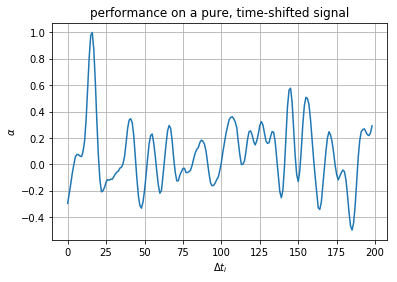

16


In [31]:
# performance on a pure, time-shifted signal
end = 300
l = 100
alpha = nndecon(s1[:end],s2[(end-l):end],method='ridge',lam=1)
plt.plot(alpha[1:-1])
plt.title('performance on a pure, time-shifted signal')
plt.xlabel('$\\Delta t_i$')
plt.ylabel('$\\alpha$')
plt.grid()
plt.show()
print(abs(alpha[1:-1]+1).argmax())

In [32]:
print()

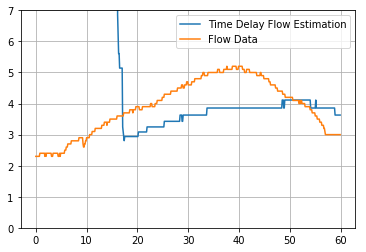

In [38]:
l = 150

tds = range(l+5,len(s2))
res = np.zeros(len(tds))

win = sig.windows.hann(l)

for i,td in enumerate(tds):
    end = td
    #print(end)
    #print(l)
    #l =100
    alpha = nndecon(s1[:end],s2[(end-l):end],method='ridge',lam=1,window=True,fast=win)
    
    res[i] = 6.17/( abs(alpha[2:-2].argmax()+2)*dt )

plt.plot(np.array(tds)*dt,res,label='Time Delay Flow Estimation')
plt.plot(t,flow,label='Flow Data')
plt.legend()
plt.grid(True)
plt.ylim(0,7)
plt.show()


In [34]:
an = 3
a = [1,2,3,4,5,6,7,8,9,10]
S = sp.linalg.toeplitz( a[-an:],np.flip( a[:-an+1] ) )
print(S)

[[ 8  7  6  5  4  3  2  1]
 [ 9  8  7  6  5  4  3  2]
 [10  9  8  7  6  5  4  3]]


In [35]:
print('foo')

foo
